In [2]:
import itertools
from functools import partial

import geopandas as gpd
import numpy as np
import pandas as pd
import vsketch
from fn.fn import new_savepath
from geodude.intersection import (
    assign_psuedoperiodic_order_to_adjacent_clusters,
    assign_random_order_to_adjacent_clusters,
    chunked_pairwise_partition_polygons, find_adjacency_clusters,
    find_contained_polys, find_intersecting_polys, find_parent_polygons,
    find_touching_polys, merge_disjoint_polys, pairwise_partition_polygons)
from geodude.line import bezier_func, dash_linestring
from geodude.ops import buft_fill, make_like
from geodude.parameter import Prm, prms
from geodude.subdivide import (bino_draw, flex_rule_recursive_split,
                               random_line_subdivide,
                               split_along_longest_side_of_min_rectangle,
                               split_poly)
from geodude.utils import (Paper, flatten_geoms, merge_LineStrings,
                           merge_Polygons)
from matplotlib import pyplot as plt
from shapely import is_valid, unary_union
from shapely.geometry import (LineString, MultiLineString, MultiPoint,
                              MultiPolygon, Point, Polygon, box)
from shapely.ops import nearest_points

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:

# make page
paper_size = '11x14 inches'
border:float=30
paper = Paper(paper_size)

drawbox = paper.get_drawbox(border)

In [14]:

n_lines = 20
xmin, ymin, xmax, ymax = drawbox.bounds
width = xmax - xmin


des_xmin = xmin + width * 0.2
des_xmax = xmax - width * 0.2
des_xrange = (des_xmin, des_xmax)


init_rel_xs = np.linspace(0, 1, n_lines)



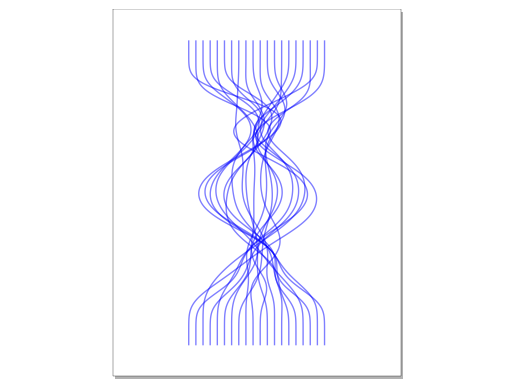

In [15]:
def get_ctrl_pts(x,):
    xs = [
        np.interp(x, [0, 1], [0, 1],),
        np.interp(x, [0, 1], [0, 1],),
        np.interp(x, [0, 1], [0, 1],),
        np.interp(x, [0, 1], [0, 1],),
        np.interp(x, [0, 1], [0, 1],),
        np.interp(x, [0, 1], [0, 1],),
        np.interp(x, [0, 1], [0, 1],),
        np.interp(x, [0, 1], [0, 1],),
        np.interp(x, [0, 1], [0, 1],),
        
        np.interp(x, [0, 1], [0, 1],),
        np.interp(x, [0, 1], [0, 1],),
        np.interp(x, [0, 1], [0, 1],),
        
        np.random.uniform(-1, 2),
        np.random.uniform(0, 2),
        np.random.uniform(0, 2),
        np.interp(x, [0, 1], [1, 0],),
        np.random.uniform(0, 1),
        np.random.uniform(0, 1),
        np.random.uniform(0, 1),
        np.interp(x, [0, 1], [1, 0],),
        np.random.uniform(0, 1),
        np.random.uniform(0, 1),
        np.random.uniform(0, 1),
        
        np.interp(x, [0, 1], [0, 1],),
        np.interp(x, [0, 1], [0, 1],),
        np.interp(x, [0, 1], [0, 1],),
        np.interp(x, [0, 1], [0, 1],),
        np.interp(x, [0, 1], [0, 1],),
        np.interp(x, [0, 1], [0, 1],),
        np.interp(x, [0, 1], [0.2, 0.8],),
        np.interp(x, [0, 1], [0, 1],),
        np.interp(x, [0, 1], [0, 1],),
        np.interp(x, [0, 1], [0, 1],),
        np.interp(x, [0, 1], [0, 1],),
        np.interp(x, [0, 1], [0, 1],),
        np.interp(x, [0, 1], [0, 1],),
        
        np.random.uniform(0, 1),
        np.random.uniform(0, 1),
        np.random.uniform(0, 1),
        np.interp(x, [0, 1], [1, 0],),
        np.random.uniform(0, 1),
        np.random.uniform(0, 1),
        np.random.uniform(0, 1),
        np.interp(x, [0, 1], [1, 0],),
        np.random.uniform(0, 1),
        np.random.uniform(0, 1),
        np.random.uniform(0, 1),
        
        np.interp(x, [0, 1], [1, 0],),
        np.interp(x, [0, 1], [1, 0],),
        np.interp(x, [0, 1], [1, 0],),
        np.interp(x, [0, 1], [1, 0],),
        np.interp(x, [0, 1], [1, 0],),
        np.interp(x, [0, 1], [1, 0],),
        np.interp(x, [0, 1], [1, 0],),
        np.interp(x, [0, 1], [1, 0],),
        np.interp(x, [0, 1], [1, 0],),
        np.interp(x, [0, 1], [1, 0],),
        np.interp(x, [0, 1], [1, 0],),
        np.interp(x, [0, 1], [1, 0],),
        
    ]
    xs = np.interp(xs, [0, 1], des_xrange,)
    ys = np.linspace(ymin, ymax, len(xs))
    return list(zip(xs, ys))


ctrl_pt_sets = [get_ctrl_pts(x) for x in init_rel_xs]
bezier_funcs = [bezier_func(ctrl_pts) for ctrl_pts in ctrl_pt_sets]
n_eval_pts = 200
eval_pts = np.linspace(0,1,n_eval_pts)
lines = [bezier_func(eval_pts) for bezier_func in bezier_funcs]

mls = MultiLineString(lines)

sk = vsketch.Vsketch()
sk.size(paper.page_format_mm)
sk.scale('1mm')
sk.penWidth('0.05mm')

sk.geometry(mls)
sk.display()

In [16]:
buffed = [l.buffer(1.4, cap_style='round') for l in mls.geoms]

In [10]:
gdf = gpd.GeoDataFrame({'geometry': buffed})

In [19]:
n_centers = 3
center_ys = np.linspace(150, 250, n_centers)
center_xs = np.linspace(110, 170, n_centers)
radii = np.random.uniform(25, 110, n_centers)
thickness = np.random.uniform(1, 7, n_centers)

circles = [Point(x, y).buffer(r, resolution=64) for x, y, r in zip(center_xs, center_ys, radii)]
rings = [c.boundary.buffer(thickness).intersection(drawbox) for c, thickness in zip(circles, thickness)]

<Axes: >

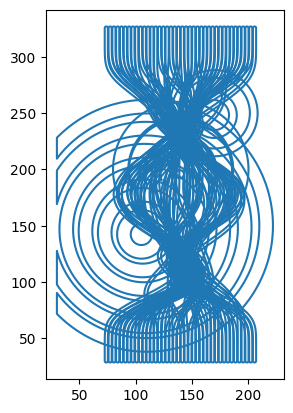

In [20]:
fills = []
for geom in circles:
    d_buffer = Prm(np.random.uniform(-20, -10))
    d_translate = Prm(lambda : d_buffer() * 0.1)
    deg = Prm(np.random.uniform(45, 90))
    polys = buft_fill(
        geom=geom, 
        d_translate=d_translate, 
        d_buffer=d_buffer, 
        deg=deg, 
        n_iters=100)
    fills.append(polys.boundary)
buffed_fills = [f.buffer(t).intersection(drawbox) for f, t in zip(fills, thickness)]
combined = pd.concat([gdf, flatten_geoms(buffed_fills)]).explode(index_parts=False).reset_index(drop=True)
combined.boundary.plot()

In [ ]:

disjoint = chunked_pairwise_partition_polygons(
    combined, 
    chunk_size=10,
    min_area=1e-3,
    verbose=True,
    )

In [27]:

disjoint = find_parent_polygons(disjoint=disjoint, original=combined)

disjoint = assign_random_order_to_adjacent_clusters(disjoint)


In [44]:

ngdf = merge_disjoint_polys(disjoint)
ngdf = ngdf.explode(index_parts=False).reset_index(drop=True)

# clean up with closing + opening
buffer_value = 1e-3
ngdf.geometry = ngdf.buffer(buffer_value).buffer(-buffer_value)
ngdf.geometry = ngdf.buffer(-buffer_value).buffer(buffer_value)
ngdf = ngdf.explode(index_parts=False).reset_index(drop=True)


In [45]:

ngdf['area'] = ngdf.area
idx = (ngdf.area > 1e-9) & ~ngdf.is_empty
# idx = idx & (ngdf.geom_type == 'Polygon')
# idx = idx & ngdf.is_valid
ngdf = ngdf[idx]

lss = [p.boundary for p in ngdf.geometry if p.boundary is not None]
mls = merge_LineStrings(lss)



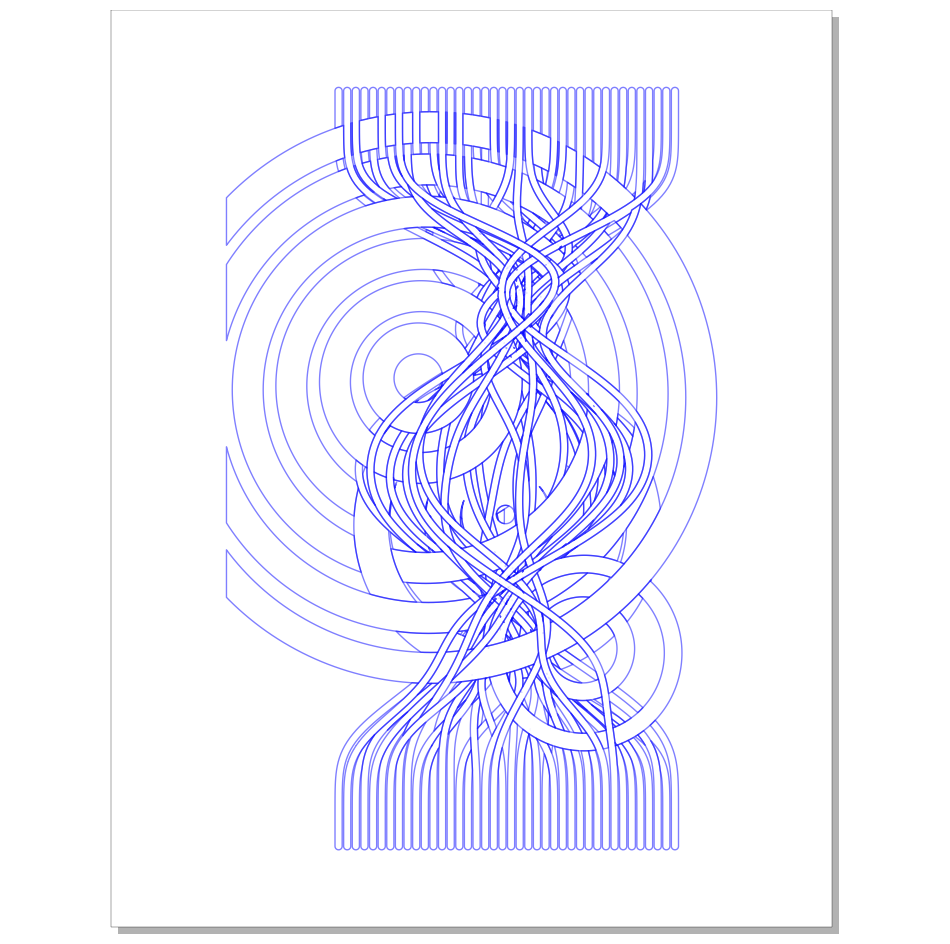

In [46]:
sk = vsketch.Vsketch()
sk.scale('1mm')
sk.penWidth('0.05mm')
sk.size(paper.page_format_mm)
sk.geometry(make_like(mls, drawbox))
sk.display(fig_size=(12,12))


In [47]:
fills = []
for geom in combined.geometry:
    d_buffer = Prm(np.random.uniform(-0.5, -0.1))
    d_translate = Prm(lambda : d_buffer() * np.random.uniform(0.4, 0.9))
    deg = Prm(np.random.uniform(230, 260))
    polys = buft_fill(
        geom=geom, 
        d_translate=d_translate, 
        d_buffer=d_buffer, 
        deg=deg, 
        n_iters=200)
    fills.append(polys.boundary)
fill_gdf = gpd.GeoDataFrame(geometry=fills)

In [48]:
sampled_ngdf = ngdf.sample(frac=1., replace=False)

In [49]:
masked = []

for ii, row in fill_gdf.iterrows():
    fill = row.geometry
    mask = sampled_ngdf.query('parent == @ii').geometry.buffer(1e-6)
    masked.append(fill.intersection(mask))
    masked.append(mask.boundary)
masked = pd.concat(masked)
masked = masked[~masked.is_empty]
fill_mls = merge_LineStrings(masked.to_list())

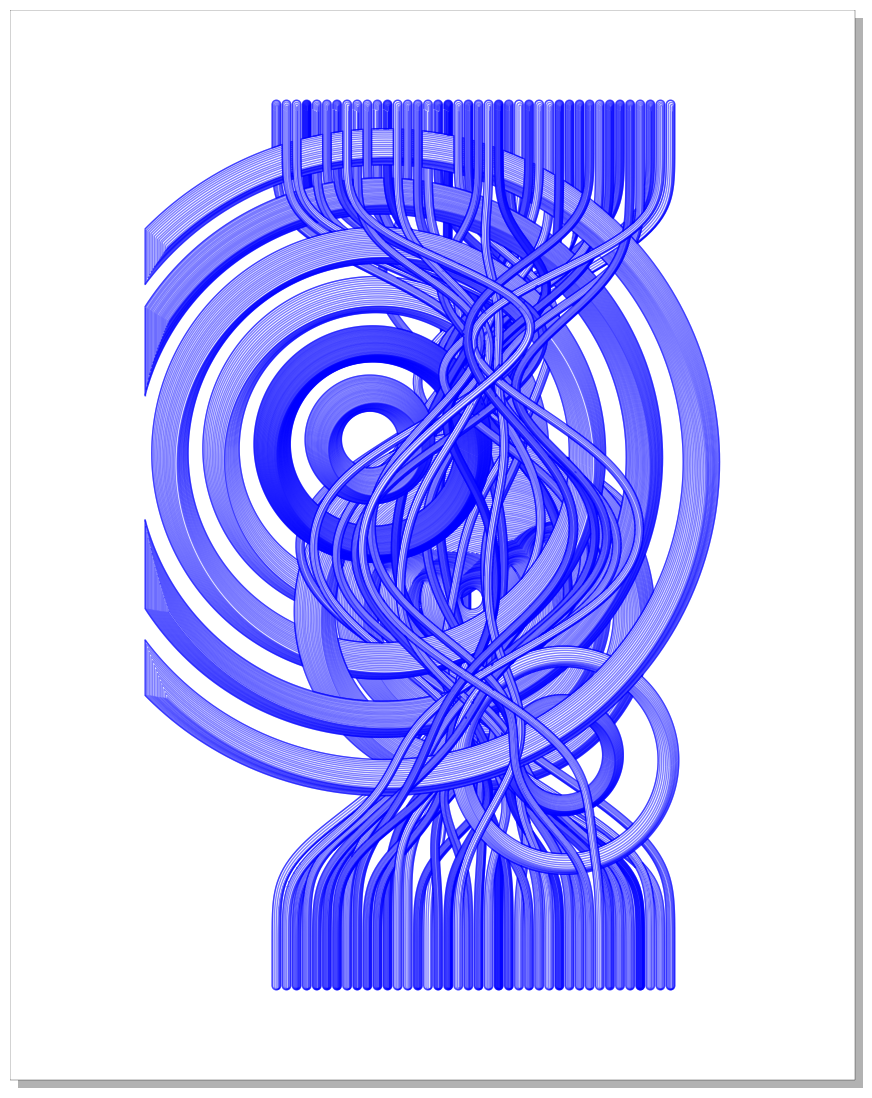

In [50]:
sk = vsketch.Vsketch()
sk.scale('1mm')
sk.penWidth('0.05mm')
sk.size(paper.page_format_mm)
sk.geometry(make_like(fill_mls, drawbox))
sk.display(fig_size=(11, 14))

In [51]:
sk.vpype('linesort')

In [52]:
fp = new_savepath(postfix='weave_and_circles_filled')
sk.save(fp)